## Load packages

In [30]:
import numpy as np
import os
import matplotlib.pyplot as plt
import csv

## Load and show data

### Matrices


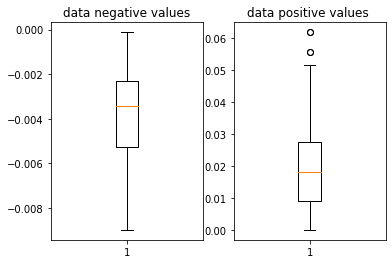

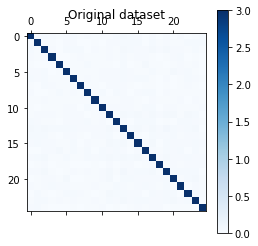

In [31]:
# Load CSV files
ISC_EEG = np.genfromtxt(os.path.join('ISC_EEG.csv'),delimiter=',')
ISC_EEG = np.array(ISC_EEG,dtype='float') # Convert into array

ISC_EDA = np.genfromtxt(os.path.join('ISC_EDA.csv'),delimiter=',')
ISC_EDA = np.array(ISC_EDA,dtype='float') # Convert into array

ISC_IBI = np.genfromtxt(os.path.join('ISC_IBI.csv'),delimiter=',')
ISC_IBI = np.array(ISC_IBI,dtype='float') # Convert into array

# Seeing if negative data have same order of magnitude as positive data 
def orderOfMagnitude(matrix):
    for i in range(len(matrix)):
        matrix[i,i] = 0
    neg = matrix[matrix<0]
    plt.subplot(121)
    plt.boxplot(neg)
    plt.title("data negative values")
    
    pos = matrix[matrix>0]
    plt.subplot(122)
    plt.boxplot(pos)
    plt.title("data positive values ")
    
# Remove outlier in array if we find one
def removeOutlierArray(matrix,subject):
    new_mat = np.copy(matrix)
    new_mat = np.delete(new_mat, (subject), axis=0)
    new_mat = np.delete(new_mat, (subject), axis=1)
    
    with open(os.path.join('ISC_truncated.csv'), 'w') as File:
        writer = csv.writer(File)
        writer.writerows(matrix)
    
    return new_mat

# Remove outlier in vector if we find one
def removeOutlierVector(vector,subject):
    new_vect = np.copy(vector)
    new_vect = np.delete(new_vect, (subject), axis=0)
    return new_vect

'''
# Remove outliers everywhere
def removeOutlier(matrix,condition,subject):
    removeOutlierArray(matrix,subject)
    removeOutlierVector(condition,subject)
'''
    
# Remove Inf in data for EDA and IBI (replace by 10 for the moment, greater than non diagonal values (1.9 for EDA and 2.5 for IBI))
for i in range(len(ISC_IBI)):
    ISC_IBI[i,i] = 100
    ISC_EDA[i,i] = 100
    
# Choose matrix to study
case = 'EEG'
removeOutlier = True # Remove outliers if there are some

if (case == 'EEG'):
    if (removeOutlier): # Remove outliers if there are some
        ISC_EEG = removeOutlierArray(ISC_EEG,3) # Really outlier?
    study_matrix = ISC_EEG
elif (case == 'EDA'):
    if (removeOutlier): # Remove outliers if there are some
        #ISC_EDA = removeOutlierArray(ISC_EDA,12) # Really outlier?
        #ISC_EDA = removeOutlierArray(ISC_EDA,20) # Really outlier?
        ISC_EDA = removeOutlierArray(ISC_EDA,17)
    study_matrix = ISC_EDA
elif (case == 'IBI'):
    if (removeOutlier): # Remove outliers if there are some
        print("Haven't found any outliers for the moment")
        # ISC_IBI = removeOutlierArray(ISC_IBI,)
    study_matrix = ISC_IBI

N = len(study_matrix)

# Boxplot
orderOfMagnitude(np.copy(study_matrix))

# Show matrix data
plt.matshow(study_matrix, cmap=plt.cm.Blues)
plt.title("Original dataset")
plt.colorbar()
plt.show()

### True groups

In [32]:
# Load true clusters
condition = np.genfromtxt(os.path.join('condition.csv'),delimiter=',')
condition = np.array(condition,dtype='int') # Convert into array
if (removeOutlier): # Remove outliers if there are some
    if (case == 'EEG'):
        condition = removeOutlierVector(condition,3) # Really outlier?
    elif (case == 'EDA'):
        #condition = removeOutlierVector(condition,12) # Really outlier?
        #condition = removeOutlierVector(condition,20) # Really outlier?
        condition = removeOutlierVector(condition,17) # Really outlier?
    elif (case == 'IBI'):
        print("Haven't found any outliers for the moment")
        # condition = removeOutlierVector(condition,) # Really outlier?

narrative = np.where(condition == 0)[0]
stimulus = np.where(condition == 1)[0]

### Compute distance matrix

In [33]:
import scipy.spatial.distance as ssd

def computeDistanceMatrix(normalisation=1,uncondensed=False): # Choose normalisation between 1 and 45, 
                                            # 45 means bigger non diagonal correlations almost 1
    # Change matrix diagonal value (kind of normalisation)
    matrix_norm = np.copy(study_matrix)
    for i in range(len(matrix_norm)):
        matrix_norm[i,i] = 0
    maxi = np.max(abs(matrix_norm)) # Max value except from the diagonal

    for i in range(len(matrix_norm)):
        #matrix_norm[i,i] = maxi
        matrix_norm[i,i] = np.max(study_matrix)/normalisation

    # Normalise max value to 1
    matrix_norm = matrix_norm / np.max(abs(matrix_norm))

    # Compute distance matrix
    #distance_matrix = np.sqrt(2*N*(1-matrix_norm))
    distance_matrix = 1-matrix_norm
    
    # Normalisation to avoid negative eigen values in PCoA
    distance_matrix = distance_matrix + add_coef
    for i in range(len(study_matrix)):
        distance_matrix[i,i] = 0
    
    # Transform matrix into unconsed matrix
    if (uncondensed):
        # convert the redundant n*n square matrix form into a condensed nC2 array
        distance_matrix = ssd.squareform(distance_matrix)
        
    ## Write new CSV file with all data
    if (uncondensed==False):
        with open(os.path.join('dist_'+ case + '.csv'), 'w') as File:
            writer = csv.writer(File)
            writer.writerows(distance_matrix)

    return distance_matrix  
    
'''
# Normalise data
for i in range(len(matrix)):
    matrix[:,i] = (matrix[:,i] - np.mean(matrix[:,i])) / np.std(matrix[:,i])
'''

'\n# Normalise data\nfor i in range(len(matrix)):\n    matrix[:,i] = (matrix[:,i] - np.mean(matrix[:,i])) / np.std(matrix[:,i])\n'

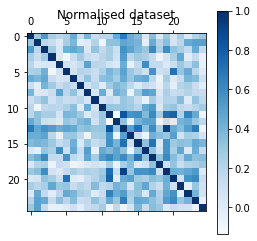

In [34]:
norm_coef = 45
add_coef = 2
distance_matrix = computeDistanceMatrix(norm_coef) # Choose between 1 and 45, 
                                            # 45 means bigger non diagonal correlations almost 1
study_matrix_norm = 1-(distance_matrix-add_coef)
for i in range(len(study_matrix)):
    study_matrix_norm[i,i] = 1

plt.matshow(study_matrix_norm, cmap=plt.cm.Blues)
plt.title("Normalised dataset")
plt.colorbar()
plt.show()

## Bloc modelling / Bi-clustering

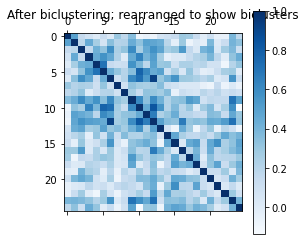

In [35]:
from sklearn.cluster import SpectralCoclustering

# Fit the model
cocluster = SpectralCoclustering(n_clusters=2, random_state=0)
cocluster.fit(study_matrix_norm)
'''
score = consensus_score(model.biclusters_,
                        (rows[:, row_idx], columns[:, col_idx]))

print("consensus score: {:.3f}".format(score))
'''
fit_data = study_matrix_norm[np.argsort(cocluster.row_labels_)]
fit_data = fit_data[:, np.argsort(cocluster.column_labels_)]

# Show results
plt.matshow(fit_data, cmap=plt.cm.Blues)
plt.title("After biclustering; rearranged to show biclusters")
plt.colorbar()
plt.show()

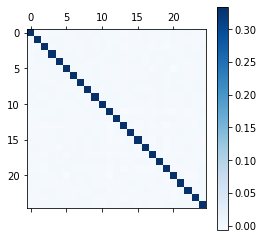

In [36]:
# Show matrix inverse (decorrelation?)
decorr = np.linalg.inv(study_matrix)

plt.matshow(decorr, cmap=plt.cm.Blues)
plt.colorbar()
plt.show()

## Hierarchical clustering

### Hierarchical clustering based on correlation (diagonal normalised)

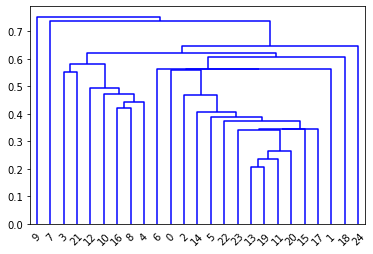

In [37]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z=linkage(study_matrix_norm,'single','correlation',optimal_ordering=True)
dendrogram(Z, color_threshold=0)
plt.show()

In [38]:
print("group 0 (NA) : ",narrative)
print("group 1 (SSA): ",stimulus)

group 0 (NA) :  [ 0  2  3  4  6  8 10 12 15 16 17 21 24]
group 1 (SSA):  [ 1  5  7  9 11 13 14 18 19 20 22 23]


### Hierarchical clustering based on euclidean distance

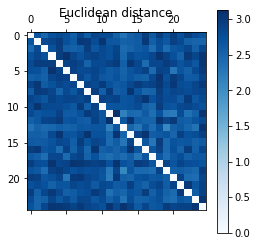

In [39]:
distance_matrix = computeDistanceMatrix(norm_coef)
plt.matshow(distance_matrix, cmap=plt.cm.Blues)
plt.title("Euclidean distance")
plt.colorbar()
plt.show()

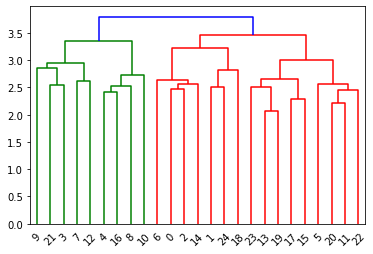

Found clusters 
[0 0 0 1 1 0 0 1 1 1 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0]
True clusters 
[0 1 0 0 0 1 0 1 0 1 0 1 0 1 1 0 0 0 1 1 1 0 1 1 0]
Well classified
[ 0  2  6  7  9 15 17 24]
Wrong classified
[ 1  3  4  5  8 10 11 12 13 14 16 18 19 20 21 22 23]
Precision : 0.320000


In [40]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

distance_matrix = computeDistanceMatrix(norm_coef,uncondensed=True)
Z=linkage(distance_matrix,'ward','euclidean',optimal_ordering=True)
thresold = 3.5
dendrogram(Z, color_threshold=thresold)
plt.show()

print("Found clusters ")
label = 1-(fcluster(Z, t=thresold, criterion='distance')-1)
print(label)
print("True clusters ")
print(condition)

subjects = np.arange(0,N)
wellClassified = subjects[label==condition]
wrongClassified = subjects[label!=condition]
SSA_HC = subjects[label==0] # Maybe NA
NA_HC = subjects[label==1] # Maybe SSA
print("Well classified")
print(wellClassified)
print("Wrong classified")
print(wrongClassified)
prec = len(wellClassified)/N
print("Precision : %f" %prec)
#[ 0  2  3  7  8 10 16 18 25]

In [41]:
print("group 0 (NA) : ",narrative)
print("group 1 (SSA): ",stimulus)

group 0 (NA) :  [ 0  2  3  4  6  8 10 12 15 16 17 21 24]
group 1 (SSA):  [ 1  5  7  9 11 13 14 18 19 20 22 23]


## Multi Dimensionnal Scaling

In [42]:
"""
Multi-dimensional Scaling (MDS)
"""

# author: Nelle Varoquaux <nelle.varoquaux@gmail.com>
# License: BSD

import numpy as np

import warnings

from sklearn.base import BaseEstimator
from sklearn.metrics import euclidean_distances
from sklearn.utils import check_random_state, check_array, check_symmetric
from sklearn.externals.joblib import Parallel
from sklearn.externals.joblib import delayed
from sklearn.isotonic import IsotonicRegression


def _smacof_single(dissimilarities, metric=True, n_components=2, init=None,
                   max_iter=300, verbose=0, eps=1e-3, random_state=None,
                   normalize=False):
    """Computes multidimensional scaling using SMACOF algorithm
    Parameters
    ----------
    dissimilarities : ndarray, shape (n_samples, n_samples)
        Pairwise dissimilarities between the points. Must be symmetric.
    metric : boolean, optional, default: True
        Compute metric or nonmetric SMACOF algorithm.
    n_components : int, optional, default: 2
        Number of dimensions in which to immerse the dissimilarities. If an
        ``init`` array is provided, this option is overridden and the shape of
        ``init`` is used to determine the dimensionality of the embedding
        space.
    init : ndarray, shape (n_samples, n_components), optional, default: None
        Starting configuration of the embedding to initialize the algorithm. By
        default, the algorithm is initialized with a randomly chosen array.
    max_iter : int, optional, default: 300
        Maximum number of iterations of the SMACOF algorithm for a single run.
    verbose : int, optional, default: 0
        Level of verbosity.
    eps : float, optional, default: 1e-3
        Relative tolerance with respect to stress at which to declare
        convergence.
    random_state : int, RandomState instance or None, optional, default: None
        The generator used to initialize the centers.  If int, random_state is
        the seed used by the random number generator; If RandomState instance,
        random_state is the random number generator; If None, the random number
        generator is the RandomState instance used by `np.random`.
    normalize : boolean, optional, default: False
        Whether use and return normed stress value (Stress-1) instead of raw
        stress calculated by default.
    Returns
    -------
    X : ndarray, shape (n_samples, n_components)
        Coordinates of the points in a ``n_components``-space.
    stress : float
        The final value of the stress. By default, sum of squared distance
        of the disparities and the distances for all constrained points.
        If normalize is set to True, returns Stress-1 (according to
        Kruskal (1964, p. 3) value 0 indicates "perfect" fit, 0.025
        excellent, 0.05 good, 0.1 fair, and 0.2 poor).
    n_iter : int
        The number of iterations corresponding to the best stress.
    """
    dissimilarities = check_symmetric(dissimilarities, raise_exception=True)

    n_samples = dissimilarities.shape[0]
    random_state = check_random_state(random_state)

    sim_flat = ((1 - np.tri(n_samples)) * dissimilarities).ravel()
    sim_flat_w = sim_flat[sim_flat != 0]
    if init is None:
        # Randomly choose initial configuration
        X = random_state.rand(n_samples * n_components)
        X = X.reshape((n_samples, n_components))
    else:
        # overrides the parameter p
        n_components = init.shape[1]
        if n_samples != init.shape[0]:
            raise ValueError("init matrix should be of shape (%d, %d)" %
                             (n_samples, n_components))
        X = init

    old_stress = None
    ir = IsotonicRegression()
    for it in range(max_iter):
        # Compute distance and monotonic regression
        dis = euclidean_distances(X)

        if metric:
            disparities = dissimilarities
        else:
            dis_flat = dis.ravel()
            # dissimilarities with 0 are considered as missing values
            dis_flat_w = dis_flat[sim_flat != 0]

            # Compute the disparities using a monotonic regression
            disparities_flat = ir.fit_transform(sim_flat_w, dis_flat_w)
            disparities = dis_flat.copy()
            disparities[sim_flat != 0] = disparities_flat
            disparities = disparities.reshape((n_samples, n_samples))
            disparities *= np.sqrt((n_samples * (n_samples - 1) / 2) /
                                   (disparities ** 2).sum())

        # Compute raw stress
        stress = ((dis.ravel() - disparities.ravel()) ** 2).sum() / 2

        # Use Stress-1
        if normalize:
            stress = np.sqrt(stress /
                             ((disparities.ravel() ** 2).sum() / 2))

        # Update X using the Guttman transform
        dis[dis == 0] = 1e-5
        ratio = disparities / dis
        B = - ratio
        B[np.arange(len(B)), np.arange(len(B))] += ratio.sum(axis=1)
        X = 1. / n_samples * np.dot(B, X)

        dis = np.sqrt((X ** 2).sum(axis=1)).sum()
        if verbose >= 2:
            print('it: %d, stress %s' % (it, stress))
        if old_stress is not None:
            if(old_stress - stress / dis) < eps:
                if verbose:
                    print('breaking at iteration %d with stress %s' % (it,
                                                                       stress))
                break
        old_stress = stress / dis

    return X, stress, it + 1


def smacof(dissimilarities, metric=True, n_components=2, init=None, n_init=8,
           n_jobs=1, max_iter=300, verbose=0, eps=1e-3, random_state=None,
           return_n_iter=False, normalize=False):
    """Computes multidimensional scaling using the SMACOF algorithm.
    The SMACOF (Scaling by MAjorizing a COmplicated Function) algorithm is a
    multidimensional scaling algorithm which minimizes an objective function
    (the *stress*) using a majorization technique. Stress majorization, also
    known as the Guttman Transform, guarantees a monotone convergence of
    stress, and is more powerful than traditional techniques such as gradient
    descent.
    The SMACOF algorithm for metric MDS can summarized by the following steps:
    1. Set an initial start configuration, randomly or not.
    2. Compute the stress
    3. Compute the Guttman Transform
    4. Iterate 2 and 3 until convergence.
    The nonmetric algorithm adds a monotonic regression step before computing
    the stress.
    Parameters
    ----------
    dissimilarities : ndarray, shape (n_samples, n_samples)
        Pairwise dissimilarities between the points. Must be symmetric.
    metric : boolean, optional, default: True
        Compute metric or nonmetric SMACOF algorithm.
    n_components : int, optional, default: 2
        Number of dimensions in which to immerse the dissimilarities. If an
        ``init`` array is provided, this option is overridden and the shape of
        ``init`` is used to determine the dimensionality of the embedding
        space.
    init : ndarray, shape (n_samples, n_components), optional, default: None
        Starting configuration of the embedding to initialize the algorithm. By
        default, the algorithm is initialized with a randomly chosen array.
    n_init : int, optional, default: 8
        Number of times the SMACOF algorithm will be run with different
        initializations. The final results will be the best output of the runs,
        determined by the run with the smallest final stress. If ``init`` is
        provided, this option is overridden and a single run is performed.
    n_jobs : int, optional, default: 1
        The number of jobs to use for the computation. If multiple
        initializations are used (``n_init``), each run of the algorithm is
        computed in parallel.
        If -1 all CPUs are used. If 1 is given, no parallel computing code is
        used at all, which is useful for debugging. For ``n_jobs`` below -1,
        (``n_cpus + 1 + n_jobs``) are used. Thus for ``n_jobs = -2``, all CPUs
        but one are used.
    max_iter : int, optional, default: 300
        Maximum number of iterations of the SMACOF algorithm for a single run.
    verbose : int, optional, default: 0
        Level of verbosity.
    eps : float, optional, default: 1e-3
        Relative tolerance with respect to stress at which to declare
        convergence.
    random_state : int, RandomState instance or None, optional, default: None
        The generator used to initialize the centers.  If int, random_state is
        the seed used by the random number generator; If RandomState instance,
        random_state is the random number generator; If None, the random number
        generator is the RandomState instance used by `np.random`.
    return_n_iter : bool, optional, default: False
        Whether or not to return the number of iterations.
    normalize : boolean, optional, default: False
        Whether use and return normed stress value (Stress-1) instead of raw
        stress calculated by default.
    Returns
    -------
    X : ndarray, shape (n_samples, n_components)
        Coordinates of the points in a ``n_components``-space.
    stress : float
        The final value of the stress. By default, sum of squared distance
        of the disparities and the distances for all constrained points.
        If normalize is set to True, returns Stress-1 (according to
        Kruskal (1964, p. 3) value 0 indicates "perfect" fit, 0.025
        excellent, 0.05 good, 0.1 fair, and 0.2 poor).
    n_iter : int
        The number of iterations corresponding to the best stress. Returned
        only if ``return_n_iter`` is set to ``True``.
    Notes
    -----
    "Modern Multidimensional Scaling - Theory and Applications" Borg, I.;
    Groenen P. Springer Series in Statistics (1997)
    "Nonmetric multidimensional scaling: a numerical method" Kruskal, J.
    Psychometrika, 29 (1964)
    "Multidimensional scaling by optimizing goodness of fit to a nonmetric
    hypothesis" Kruskal, J. Psychometrika, 29, (1964)
    """

    dissimilarities = check_array(dissimilarities)
    random_state = check_random_state(random_state)

    if hasattr(init, '__array__'):
        init = np.asarray(init).copy()
        if not n_init == 1:
            warnings.warn(
                'Explicit initial positions passed: '
                'performing only one init of the MDS instead of %d'
                % n_init)
            n_init = 1

    best_pos, best_stress = None, None

    if n_jobs == 1:
        for it in range(n_init):
            pos, stress, n_iter_ = _smacof_single(
                dissimilarities, metric=metric,
                n_components=n_components, init=init,
                max_iter=max_iter, verbose=verbose,
                eps=eps, random_state=random_state,
                normalize=normalize)
            if best_stress is None or stress < best_stress:
                best_stress = stress
                best_pos = pos.copy()
                best_iter = n_iter_
    else:
        seeds = random_state.randint(np.iinfo(np.int32).max, size=n_init)
        results = Parallel(n_jobs=n_jobs, verbose=max(verbose - 1, 0))(
            delayed(_smacof_single)(
                dissimilarities, metric=metric, n_components=n_components,
                init=init, max_iter=max_iter, verbose=verbose, eps=eps,
                random_state=seed, normalize=normalize)
            for seed in seeds)
        positions, stress, n_iters = zip(*results)
        best = np.argmin(stress)
        best_stress = stress[best]
        best_pos = positions[best]
        best_iter = n_iters[best]

    if return_n_iter:
        return best_pos, best_stress, best_iter
    else:
        return best_pos, best_stress


class MDS(BaseEstimator):
    """Multidimensional scaling
    Read more in the :ref:`User Guide <multidimensional_scaling>`.
    Parameters
    ----------
    n_components : int, optional, default: 2
        Number of dimensions in which to immerse the dissimilarities.
    metric : boolean, optional, default: True
        If ``True``, perform metric MDS; otherwise, perform nonmetric MDS.
    n_init : int, optional, default: 4
        Number of times the SMACOF algorithm will be run with different
        initializations. The final results will be the best output of the runs,
        determined by the run with the smallest final stress.
    max_iter : int, optional, default: 300
        Maximum number of iterations of the SMACOF algorithm for a single run.
    verbose : int, optional, default: 0
        Level of verbosity.
    eps : float, optional, default: 1e-3
        Relative tolerance with respect to stress at which to declare
        convergence.
    n_jobs : int, optional, default: 1
        The number of jobs to use for the computation. If multiple
        initializations are used (``n_init``), each run of the algorithm is
        computed in parallel.
        If -1 all CPUs are used. If 1 is given, no parallel computing code is
        used at all, which is useful for debugging. For ``n_jobs`` below -1,
        (``n_cpus + 1 + n_jobs``) are used. Thus for ``n_jobs = -2``, all CPUs
        but one are used.
    random_state : int, RandomState instance or None, optional, default: None
        The generator used to initialize the centers.  If int, random_state is
        the seed used by the random number generator; If RandomState instance,
        random_state is the random number generator; If None, the random number
        generator is the RandomState instance used by `np.random`.
    dissimilarity : 'euclidean' | 'precomputed', optional, default: 'euclidean'
        Dissimilarity measure to use:
        - 'euclidean':
            Pairwise Euclidean distances between points in the dataset.
        - 'precomputed':
            Pre-computed dissimilarities are passed directly to ``fit`` and
            ``fit_transform``.
    normalize : boolean, optional, default: False
        Whether use and return normed stress value (Stress-1) instead of raw
        stress calculated by default.
    Attributes
    ----------
    embedding_ : array-like, shape (n_components, n_samples)
        Stores the position of the dataset in the embedding space.
    stress_ : float
        The final value of the stress. By default, sum of squared distance
        of the disparities and the distances for all constrained points.
        If normalize is set to True, returns Stress-1 (according to
        Kruskal (1964, p. 3) value 0 indicates "perfect" fit, 0.025
        excellent, 0.05 good, 0.1 fair, and 0.2 poor).
    References
    ----------
    "Modern Multidimensional Scaling - Theory and Applications" Borg, I.;
    Groenen P. Springer Series in Statistics (1997)
    "Nonmetric multidimensional scaling: a numerical method" Kruskal, J.
    Psychometrika, 29 (1964)
    "Multidimensional scaling by optimizing goodness of fit to a nonmetric
    hypothesis" Kruskal, J. Psychometrika, 29, (1964)
    """
    def __init__(self, n_components=2, metric=True, n_init=4,
                 max_iter=300, verbose=0, eps=1e-3, n_jobs=1,
                 random_state=None, dissimilarity="euclidean",normalize = False):
        self.n_components = n_components
        self.dissimilarity = dissimilarity
        self.metric = metric
        self.n_init = n_init
        self.max_iter = max_iter
        self.eps = eps
        self.verbose = verbose
        self.n_jobs = n_jobs
        self.random_state = random_state
        self.normalize = normalize

    @property
    def _pairwise(self):
        return self.kernel == "precomputed"

    def fit(self, X, y=None, init=None):
        """
        Computes the position of the points in the embedding space
        Parameters
        ----------
        X : array, shape (n_samples, n_features) or (n_samples, n_samples)
            Input data. If ``dissimilarity=='precomputed'``, the input should
            be the dissimilarity matrix.
        y: Ignored
        init : ndarray, shape (n_samples,), optional, default: None
            Starting configuration of the embedding to initialize the SMACOF
            algorithm. By default, the algorithm is initialized with a randomly
            chosen array.
        """
        self.fit_transform(X, init=init)
        return self

    def fit_transform(self, X, y=None, init=None):
        """
        Fit the data from X, and returns the embedded coordinates
        Parameters
        ----------
        X : array, shape (n_samples, n_features) or (n_samples, n_samples)
            Input data. If ``dissimilarity=='precomputed'``, the input should
            be the dissimilarity matrix.
        y: Ignored
        init : ndarray, shape (n_samples,), optional, default: None
            Starting configuration of the embedding to initialize the SMACOF
            algorithm. By default, the algorithm is initialized with a randomly
            chosen array.
        """
        X = check_array(X)
        if X.shape[0] == X.shape[1] and self.dissimilarity != "precomputed":
            warnings.warn("The MDS API has changed. ``fit`` now constructs an"
                          " dissimilarity matrix from data. To use a custom "
                          "dissimilarity matrix, set "
                          "``dissimilarity='precomputed'``.")

        if self.dissimilarity == "precomputed":
            self.dissimilarity_matrix_ = X
        elif self.dissimilarity == "euclidean":
            self.dissimilarity_matrix_ = euclidean_distances(X)
        else:
            raise ValueError("Proximity must be 'precomputed' or 'euclidean'."
                             " Got %s instead" % str(self.dissimilarity))

        self.embedding_, self.stress_, self.n_iter_ = smacof(
            self.dissimilarity_matrix_, metric=self.metric,
            n_components=self.n_components, init=init, n_init=self.n_init,
            n_jobs=self.n_jobs, max_iter=self.max_iter, verbose=self.verbose,
            eps=self.eps, random_state=self.random_state,
            return_n_iter=True,normalize=self.normalize)

        return self.embedding_

### Modified scikit MDS (because there is no normalised stress)

In [43]:
# MDS with normalised stress
def computeMDSCoordinate(n_comp,distance_matrix,metric=True,printStress=False,dissimilarity='precomputed'):
    mds = MDS(n_components=n_comp,random_state=1,normalize=True,eps=1e-10,metric=metric,dissimilarity=dissimilarity)
    mds.fit(distance_matrix)
    points = mds.embedding_
    stress = mds.stress_
    '''
    Stress-1 that according to Kruskal (1964, p. 3) has more or less 
    the following interpretation: value 0 indicates perfect fit, 
    0.025 excellent, 0.05 good, 0.1 fair and 0.2 poor.
    '''
    if (printStress):
        print("Stress of the method : %f" %stress)
    return points, stress

### Scikit MDS

In [44]:
# Scikit MDS
from sklearn import manifold

def mdsScikit(n_comp,distance_matrix,dissimilarity='precomputed'):
    mds = manifold.MDS(n_components=n_comp,random_state=1,dissimilarity=dissimilarity,eps=1e-10)
    mds.fit(distance_matrix)
    points = mds.embedding_
    stress = mds.stress_

    '''
    # Normalise data
    for i in range(n_comp):
        points[:,i] = (points[:,i] - np.mean(points[:,i])) / np.std(points[:,i])
    '''
    return points

### Show MDS results

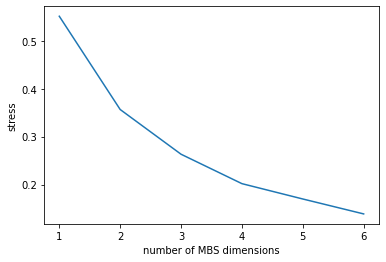

In [45]:
from sklearn.decomposition import PCA

# Make PCA to project MDS data in 2D
def transformPoints(points,n_comp=2):
    if (points.shape[1] != 2):
        # Normalise data
        for i in range(len(points[1,:])):
            points[:,i] = (points[:,i] - np.mean(points[:,i])) / np.std(points[:,i])

        pca = PCA(n_components=n_comp)
        points = pca.fit_transform(points)
        print("%f variance explained when plotting" %sum(pca.explained_variance_ratio_[:n_comp]))
    return points

# Show MDS scaling
import matplotlib.patches as mpatches

def plotMdsPoints(points,projection=False,title='Ground truth'):
    ax = plt.axes([1.2,0,1.2,1.2])
    ax.set_aspect(aspect='equal')
    if (projection):
        points = transformPoints(points)
    
    for i in range(len(condition)):
        if (condition[i] == 0):
            color = 'blue'
        else:
            color = 'red'
        ax.annotate(i,(points[i,0],points[i,1]),xytext=(points[i,0]+0.07,points[i,1]))

    plt.scatter(points[narrative,0],points[narrative,1],color='blue',s=145,label='NA')
    plt.scatter(points[stimulus,0],points[stimulus,1],color='red',s=145,label='SSA')
    
    NA = mpatches.Patch(color='blue', label='NA')
    SSA = mpatches.Patch(color='red', label='SSA')
    plt.legend(handles=[NA,SSA])
    
    plt.title(title)

# Find best MDS dimension
stress = np.zeros((int(N/4),1)) # dimension rule : dimension < N/4 
distance_matrix = computeDistanceMatrix(norm_coef)
for i in range(1,int(N/4)+1):
    points,stress[i-1] = computeMDSCoordinate(i,distance_matrix)

plt.plot(np.arange(1,int(N/4)+1),stress)
plt.xlabel("number of MBS dimensions")
plt.ylabel("stress")

# EEG : 6
# EDA : 3 or 4
mdsDim = 6


0.361605 variance explained when plotting
Stress of the method : 0.138930
0.361605 variance explained when plotting


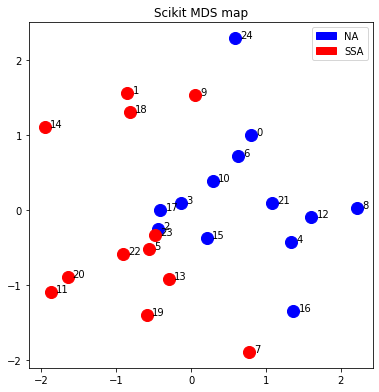

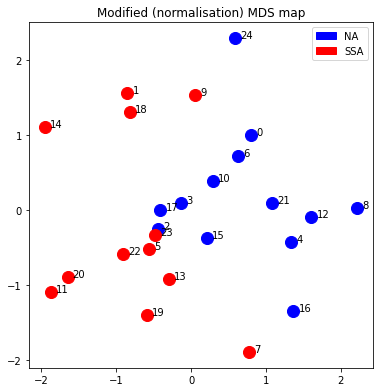

In [46]:
# MDS with Normalised stress
points = mdsScikit(mdsDim,distance_matrix,dissimilarity='precomputed')
plotMdsPoints(points,projection=True,title='Scikit MDS map')
plt.figure()
points,stress = computeMDSCoordinate(mdsDim,distance_matrix,dissimilarity='precomputed',printStress=True)
plotMdsPoints(points,projection=True,title='Modified (normalisation) MDS map')

## Deterministic PCoA

pcoa proportion explained : 0.17751372807237736 


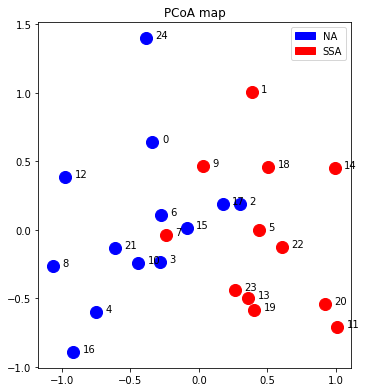

In [47]:
from skbio.stats.ordination import pcoa

def computePCoACoordinate(distance_matrix,n_comp=2):
    
    pcoa_map = pcoa(distance_matrix, method='eigh', number_of_dimensions=n_comp)
    #print(pcoa_map.proportion_explained)
    print("pcoa proportion explained : %s " %np.sum(pcoa_map.proportion_explained))
    #print("eigen values")
    #print(pcoa_map.eigvals)
    points = np.array(pcoa_map.samples)
    return points

distance_matrix = computeDistanceMatrix(norm_coef)
points = computePCoACoordinate(distance_matrix,2)
points = transformPoints(points)
plotMdsPoints(points,title='PCoA map')

## t-SNE

pcoa proportion explained : 0.17751372807237736 
[t-SNE] Computing 13 nearest neighbors...
[t-SNE] Indexed 25 samples in 0.000s...
[t-SNE] Computed neighbors for 25 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 25 / 25
[t-SNE] Mean sigma: 0.216482
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.790726
[t-SNE] KL divergence after 2350 iterations: 0.553387


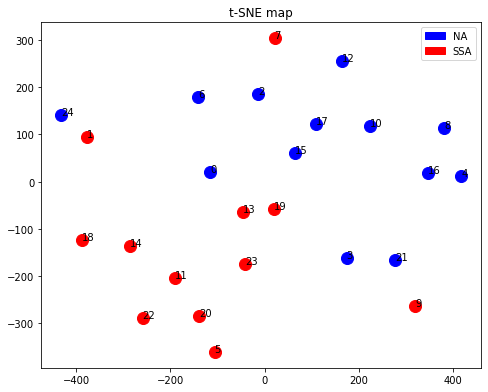

In [48]:
from sklearn.manifold import TSNE
import time
def computeSNECoordinate(distance_matrix,n_pcoa_comp=2,n_tsne_comp=2):
    #points,stress = computeMDSCoordinate(mdsDim,distance_matrix,dissimilarity='precomputed',printStress=True)
    pcoa_points = computePCoACoordinate(distance_matrix,n_pcoa_comp)
    points_lessD = transformPoints(pcoa_points,n_tsne_comp)
    tsne = TSNE(n_components=n_tsne_comp, verbose=1, perplexity=4, n_iter=30000,metric="precomputed", init=points_lessD)
    tsne_points = tsne.fit_transform(distance_matrix)
    tsne_points = transformPoints(tsne_points)
    return tsne_points
    
distance_matrix = computeDistanceMatrix(norm_coef)
points = computeSNECoordinate(distance_matrix)
plotMdsPoints(points,title='t-SNE map')

## DBSCAN (here with option "precomputed metric" -> array of distances)

In [49]:
from sklearn.cluster import DBSCAN

# Compute DBSCAN
distance_matrix = computeDistanceMatrix()
db = DBSCAN(eps=1, min_samples=1,metric='precomputed').fit(distance_matrix)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 25


0.338434 variance explained when plotting
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
no plot
0.338434 variance explained when plotting


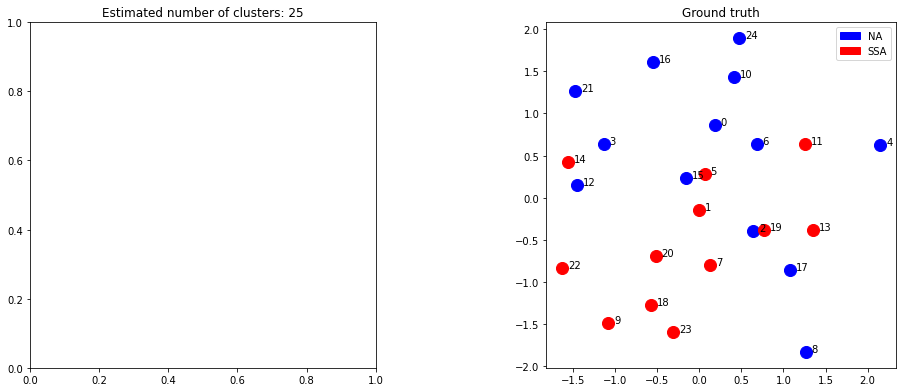

In [50]:
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

ax = plt.axes([0,0,1.2,1.2])
ax.set_aspect(aspect='equal')
distance_matrix = computeDistanceMatrix()
points,stress = computeMDSCoordinate(mdsDim,distance_matrix,dissimilarity='precomputed')
points_lessD = transformPoints(points)

for k, col in zip(unique_labels, colors):

    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)
    xy = points[class_member_mask & core_samples_mask]
    try:
        plt.plot(xy[:, 0], points[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)
    except:
        print("no plot")
    xy = points[class_member_mask & ~core_samples_mask]
    try:
        plt.plot(xy[:, 0], points[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)
    except:
        print("no plot")
        
plt.title('Estimated number of clusters: %d' % n_clusters_)

# Compare to ground truth
plotMdsPoints(points,projection=True)

## Mean Shift (to do on coordinates)

pcoa proportion explained : 0.17751372807237736 
[t-SNE] Computing 13 nearest neighbors...
[t-SNE] Indexed 25 samples in 0.000s...
[t-SNE] Computed neighbors for 25 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 25 / 25
[t-SNE] Mean sigma: 0.216482
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.790726
[t-SNE] KL divergence after 2350 iterations: 0.553387
number of estimated clusters : 5


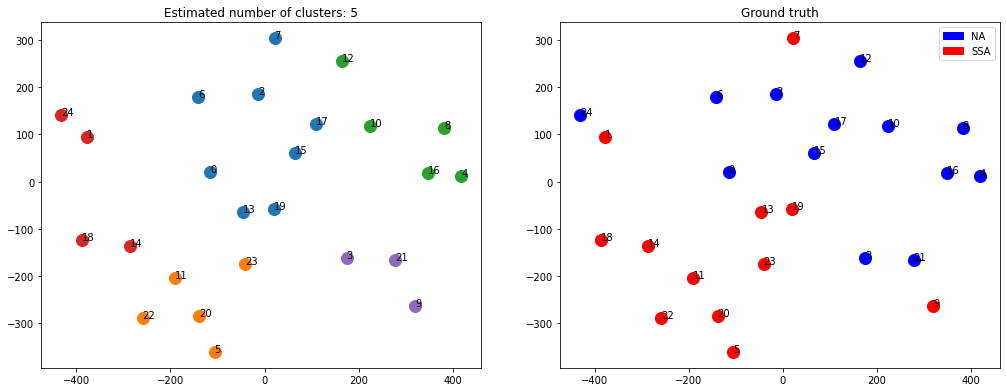

In [51]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Compute clustering with MeanShift
distance_matrix = computeDistanceMatrix(norm_coef)
points = computeSNECoordinate(distance_matrix)

# Compare to ground truth
plotMdsPoints(points,projection=True)

# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(points, quantile=0.2)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(points)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

# Plot result
from itertools import cycle

ax = plt.axes([0,0,1.2,1.2])
ax.set_aspect(aspect='equal')
#points = transformPoints(points)

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    ax.scatter(points[my_members, 0], points[my_members, 1], s=145)
    
    subjects = np.arange(0,N)
    for i in subjects[my_members==1]:
        ax.annotate(i,(points[i,0],points[i,1]),xytext=(points[i,0]+0.07,points[i,1]))
    
    plt.title('Estimated number of clusters: %d' % n_clusters_)

## 2-cluster methods

In [52]:
class Results():

    def __init__(self,name):
        self.prec = np.zeros((int(N/4)+1,len(coefficients)))
        self.best_dim = 0
        self.best_norm = 0
        self.label = np.zeros((N,1))
        self.wellClassified = None
        self.wrongClassified = None
        self.name = name
        self.best_points = np.zeros((N,2))
        
    def applyMethod(self,method,dim=np.arange(1,int(N/4)+2)):
        print("Computing clustering\n")
        for p in range(len(coefficients)):
            print(str(int(p*100/len(coefficients))) + "%")
            distance_matrix = computeDistanceMatrix(normalisation=coefficients[p])

            for i in dim:
                if (i<int(N/4)+1):
                    points,stress = computeMDSCoordinate(i,distance_matrix)
                else:
                    points = computeSNECoordinate(distance_matrix)
                meth = method.fit(points)
                if hasattr(meth, 'labels_'):
                    self.prec[i-1,p] = sum(condition==meth.labels_)/N
                else:
                    label = meth.predict(points)
                    self.prec[i-1,p] = sum(condition==label)/N
                
                if self.prec[i-1,p] == np.max(self.prec):
                    if hasattr(meth, 'labels_'):
                        self.label = meth.labels_
                    else:
                        self.label = meth.predict(points)
                    self.best_dim = i
                    self.best_norm = coefficients[p]
                    self.best_points = points
    
    def initCenters(self,NA_ref,SSA_ref):
        distance_matrix = computeDistanceMatrix(normalisation=coefficients[0])
        points = computeSNECoordinate(distance_matrix)
        init = np.zeros((2,2))
        init[:,0] = np.mean(points[NA_ref,:],axis=0)
        init[:,1] = np.mean(points[SSA_ref,:],axis=0)
        return init
    
    def trueWrongClusters(self,label,condition):
        subjects = np.arange(0,N)
        self.wellClassified = subjects[label==condition]
        self.wrongClassified = subjects[label!=condition]
        
    def twoClustersMethodResult(self):
        # Plot clustering precision with increasing dimension
        for p in range(len(coefficients)):
            plt.plot(np.arange(1,int(N/4)+2),self.prec[:,p],label=str(coefficients[p]))
        plt.xlabel("number of mds dimensions")
        plt.ylabel("%s precision" %self.name)
        plt.legend()

        print("Results\n")
        print("Best dimension %d (7 means t-SNE)" %self.best_dim)
        print("Best normalisation %d " %self.best_norm)
        print("Found clusters ")
        print(self.label)
        print("True clusters ")
        print(condition)
        self.trueWrongClusters(self.label,condition)
        print("Well classified")
        print(self.wellClassified)
        print("Wrong classified")
        print(self.wrongClassified)
        print("Best %s precision : %f" %(self.name,np.max(self.prec)))
        
    def showResultMap(self):
        plt.figure()
        ax = plt.axes([0,0,1.2,1.2])
        ax.set_aspect(aspect='equal')
                
        for i in range(N):
            if (i in self.wellClassified):
                if (condition[i] == 0):
                    color = 'blue'
                    label = 'NA'
                else:
                    color = 'red'
                    label = 'SSA'
            else:
                color = 'black'
                label = 'misclassified'
            ax.annotate(i,(self.best_points[i,0],self.best_points[i,1]),xytext=(self.best_points[i,0]+0.07,self.best_points[i,1]))
            ax.scatter(self.best_points[i,0],self.best_points[i,1],color=color,s=145,label=label)

        TP = mpatches.Patch(color='blue', label='NA')
        TN = mpatches.Patch(color='red', label='SSA')
        FP_FN = mpatches.Patch(color='black', label='misclassified')
        plt.legend(handles=[TP,TN,FP_FN])
        plt.title("%s clustering" %self.name)

### K-Means

In [53]:
from sklearn.cluster import KMeans

coefficients = np.linspace(1,45,2)
coefficients = [45]

kmeans_result = Results("k-means")
#kmeans = KMeans(n_clusters=2,n_init=1000)
#init_EEG = np.array([[-0.5,0.5],[1,0]])
init_EEG = kmeans_result.initCenters(NA_HC,SSA_HC) # Only if one coefficient and one dimension, 
                                       # otherwise we have to compute it again
kmeans = KMeans(n_clusters=2, init=init_EEG,n_init=1)
kmeans_result.applyMethod(kmeans,dim=[7])

pcoa proportion explained : 0.17751372807237736 
[t-SNE] Computing 13 nearest neighbors...
[t-SNE] Indexed 25 samples in 0.000s...
[t-SNE] Computed neighbors for 25 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 25 / 25
[t-SNE] Mean sigma: 0.216482
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.790726
[t-SNE] KL divergence after 2350 iterations: 0.553387
Computing clustering

0%
pcoa proportion explained : 0.17751372807237736 
[t-SNE] Computing 13 nearest neighbors...
[t-SNE] Indexed 25 samples in 0.000s...
[t-SNE] Computed neighbors for 25 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 25 / 25
[t-SNE] Mean sigma: 0.216482
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.790726
[t-SNE] KL divergence after 2350 iterations: 0.553387


Results

Best dimension 7 (7 means t-SNE)
Best normalisation 45 
Found clusters 
[1 1 0 0 0 1 1 0 0 0 0 1 0 1 1 0 0 0 1 1 1 0 1 1 1]
True clusters 
[0 1 0 0 0 1 0 1 0 1 0 1 0 1 1 0 0 0 1 1 1 0 1 1 0]
Well classified
[ 1  2  3  4  5  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Wrong classified
[ 0  6  7  9 24]
Best k-means precision : 0.800000


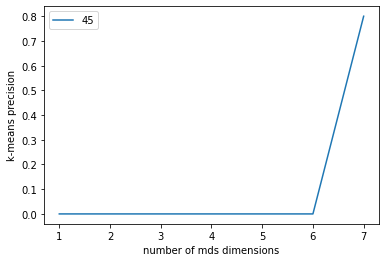

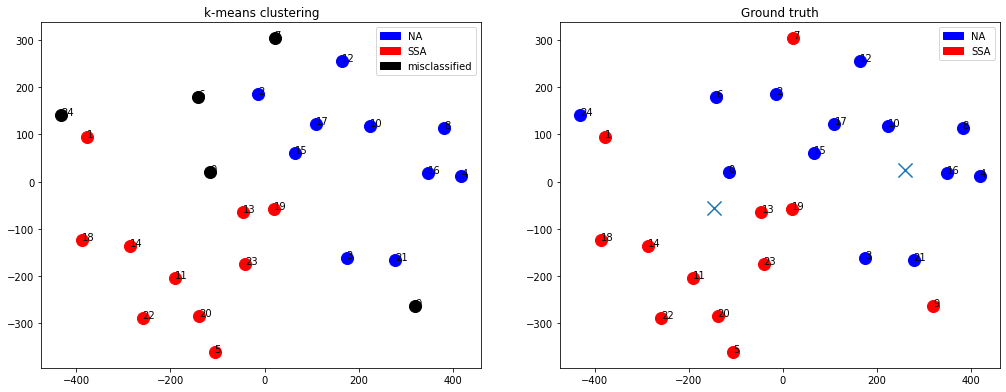

In [54]:
# Show results
kmeans_result.twoClustersMethodResult()
kmeans_result.showResultMap()
plotMdsPoints(kmeans_result.best_points)
plt.scatter(init_EEG[0,:],init_EEG[1,:],s=200,marker='x')

### Spectral Clustering

In [55]:
from sklearn.cluster import SpectralClustering

coefficients = np.linspace(1,45,2)
coefficients = [45]

spectralClustering_result = Results("spectral clustering")
spectralClustering = SpectralClustering(n_clusters=2, n_init=1000)
spectralClustering_result.applyMethod(spectralClustering,dim=[7])

Computing clustering

0%
pcoa proportion explained : 0.17751372807237736 
[t-SNE] Computing 13 nearest neighbors...
[t-SNE] Indexed 25 samples in 0.000s...
[t-SNE] Computed neighbors for 25 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 25 / 25
[t-SNE] Mean sigma: 0.216482
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.790726
[t-SNE] KL divergence after 2350 iterations: 0.553387


//anaconda3/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Results

Best dimension 7 (7 means t-SNE)
Best normalisation 45 
Found clusters 
[0 0 0 1 1 0 1 1 1 1 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0]
True clusters 
[0 1 0 0 0 1 0 1 0 1 0 1 0 1 1 0 0 0 1 1 1 0 1 1 0]
Well classified
[ 0  2  7  9 10 12 14 15 16 21 22 24]
Wrong classified
[ 1  3  4  5  6  8 11 13 17 18 19 20 23]
Best spectral clustering precision : 0.480000


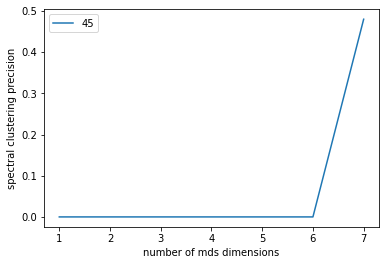

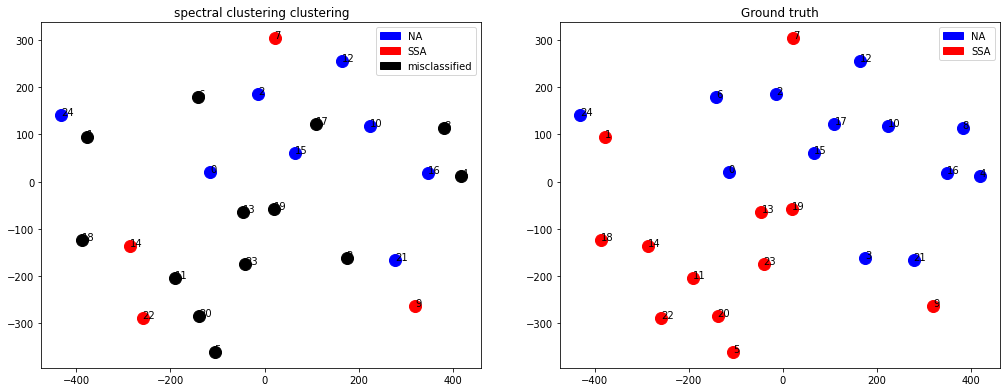

In [56]:
# Show results
spectralClustering_result.twoClustersMethodResult()
spectralClustering_result.showResultMap()
plotMdsPoints(spectralClustering_result.best_points)

### GMM

In [57]:
from sklearn.mixture import GaussianMixture

coefficients = np.linspace(1,45,2)
coefficients = [45]

gmm_result = Results("gaussian mixture")
gmm = GaussianMixture(n_components=2, n_init=1000)
gmm_result.applyMethod(gmm,dim=[7])

Computing clustering

0%
pcoa proportion explained : 0.17751372807237736 
[t-SNE] Computing 13 nearest neighbors...
[t-SNE] Indexed 25 samples in 0.000s...
[t-SNE] Computed neighbors for 25 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 25 / 25
[t-SNE] Mean sigma: 0.216482
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.790726
[t-SNE] KL divergence after 2350 iterations: 0.553387


Results

Best dimension 7 (7 means t-SNE)
Best normalisation 45 
Found clusters 
[1 0 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 0 1 0 1 0 1 0]
True clusters 
[0 1 0 0 0 1 0 1 0 1 0 1 0 1 1 0 0 0 1 1 1 0 1 1 0]
Well classified
[ 7  9 13 19 23 24]
Wrong classified
[ 0  1  2  3  4  5  6  8 10 11 12 14 15 16 17 18 20 21 22]
Best gaussian mixture precision : 0.240000


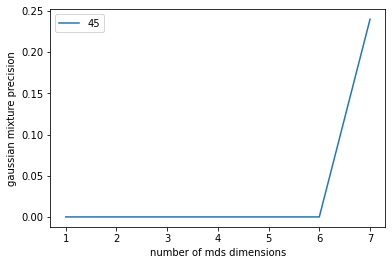

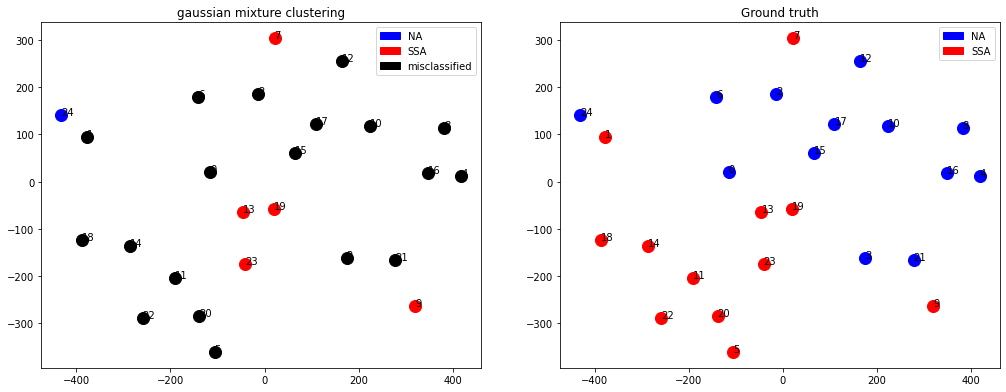

In [58]:
# Show results
gmm_result.twoClustersMethodResult()
gmm_result.showResultMap()
plotMdsPoints(gmm_result.best_points)